## Part 4) Does an LLM perform better on 2007 or 2024 ?

In [1]:
# Import librairies
import pandas as pd
from scipy.stats import ttest_ind

from src.utils.llm_plot import *
from src.utils.llm_metric import *
from src.utils.llm_processing import *

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Define consant
DATA = "data/"

Loading players games data on 2007 and LLMs (mistral, llama3) games data for 2007 and 2024

In [3]:
# Load data

## llama3 8B
llama3_2007 = pd.read_csv(DATA + "llama3/llm_paths.csv",index_col=['start', 'end'])
llama3_2024 = pd.read_csv(DATA + "llama3/llm_paths2024.csv",index_col=['start', 'end'])

## mistral 7B
mistral_2007 = pd.read_csv(DATA + "mistral/llm_paths.csv",index_col=['start', 'end'])
mistral_2024 = pd.read_csv(DATA + "mistral/llm_paths2024.csv",index_col=['start', 'end'])

## Player 2007
players_2007 = pd.read_csv(DATA + "wikispeedia_paths-and-graph/paths_finished.tsv",sep='\t', comment='#', names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])

In [4]:
players_2007=process_player_path_data(players_2007)

### Compare LLMs with the players

**Warning** : At the moment we should be critical about the results, because the llms only played each game once. In the future, we will have several games to compare in order to increase the confidence in the results.

Goal choose the llm that performs the most similar to the players.



Text(0.5, 1.0, 'Number of paths not found by model and year')

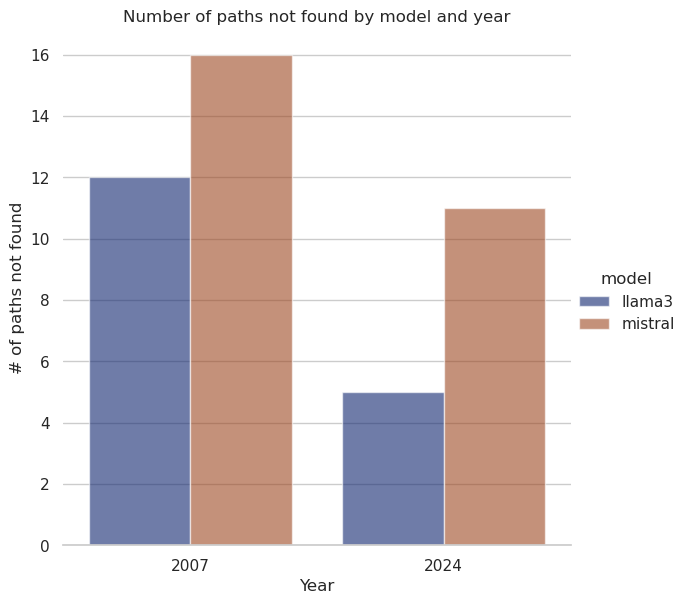

In [5]:
## count null paths for all model
llama3_2007_null = llama3_2007["path"].isnull().sum()
llama3_2024_null = llama3_2024["path"].isnull().sum()
mistral_2007_null = mistral_2007["path"].isnull().sum()
mistral_2024_null = mistral_2024["path"].isnull().sum()

null_paths = pd.DataFrame({ "model": ["llama3", "llama3", "mistral", "mistral"], "year": [2007, 2024, 2007, 2024], "null_paths": [llama3_2007_null, llama3_2024_null, mistral_2007_null, mistral_2024_null]})

sns.set_theme(style="whitegrid")
g = sns.catplot(x="year", y="null_paths", hue="model", data=null_paths, kind="bar", height=6, alpha=.6, palette="dark",errorbar="sd")
g.despine(left=True)
g.set_axis_labels("Year", "# of paths not found")
plt.title("Number of paths not found by model and year")

Mistral seems to have an harder time finding a path than llama3.

Data cleaning : removing the games that the llms did not finish and process path given by the llms by removing periodic loops, consecutive duplicates, cut the list to the first occurence of the target word.


In [6]:
# drop null paths
llama3_2007 = llama3_2007.dropna()
llama3_2024 = llama3_2024.dropna()
mistral_2007 = mistral_2007.dropna()
mistral_2024 = mistral_2024.dropna()

# transform path str(list) to list
llama3_2007["path"] = llama3_2007["path"].apply(lambda x: x[1:-1].replace("'", "").replace(" ", "").split(','))
llama3_2024["path"] = llama3_2024["path"].apply(lambda x: x[1:-1].replace("'", "").replace(" ", "").split(','))
mistral_2007["path"] = mistral_2007["path"].apply(lambda x: x[1:-1].replace("'", "").replace(" ", "").split(','))
mistral_2024["path"] = mistral_2024["path"].apply(lambda x: x[1:-1].replace("'", "").replace(" ", "").split(','))

In [7]:
# Post processing on paths 
llama3_2007["path"] = llama3_2007["path"].apply(post_processing)
llama3_2024["path"] = llama3_2024["path"].apply(post_processing)
mistral_2007["path"] = mistral_2007["path"].apply(post_processing)
mistral_2024["path"] = mistral_2024["path"].apply(post_processing)

In [8]:
llama3_2007["length"] = llama3_2007["path"].apply(len)
llama3_2024["length"] = llama3_2024["path"].apply(len)
mistral_2007["length"] = mistral_2007["path"].apply(len)
mistral_2024["length"] = mistral_2024["path"].apply(len)

In [9]:
# Compute the average length of the path for each model
avglen = pd.DataFrame(players_2007["length"].groupby(by=['start', 'end']).agg(['mean', 'std', 'median', 'count']))
avglen = pd.merge(avglen, llama3_2007['length'], left_index=True, right_index=True)
avglen = avglen.rename(columns={'length':'llama3_2007'})
avglen = pd.merge(avglen, llama3_2024['length'], left_index=True, right_index=True)
avglen = avglen.rename(columns={'length':'llama3_2024'})
avglen = pd.merge(avglen, mistral_2007['length'], left_index=True, right_index=True)
avglen = avglen.rename(columns={'length':'mistral_2007'})
avglen = pd.merge(avglen, mistral_2024['length'], left_index=True, right_index=True)
avglen = avglen.rename(columns={'length':'mistral_2024'})

In [10]:
avglen.reset_index(inplace=True)

In [11]:
generate_performance_scatter(avglen)

/home/jan/dev/ma1/ada/ada-2024-project-outlier-1/src/utils/llm_plot.py:53: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Number of LLM games in CI from player games: 66.66666666666666%
Number of Mistral games in CI from player games: 59.42028985507246%


Text(0.5, 1.0, 'Percentage of games in CI from player games')

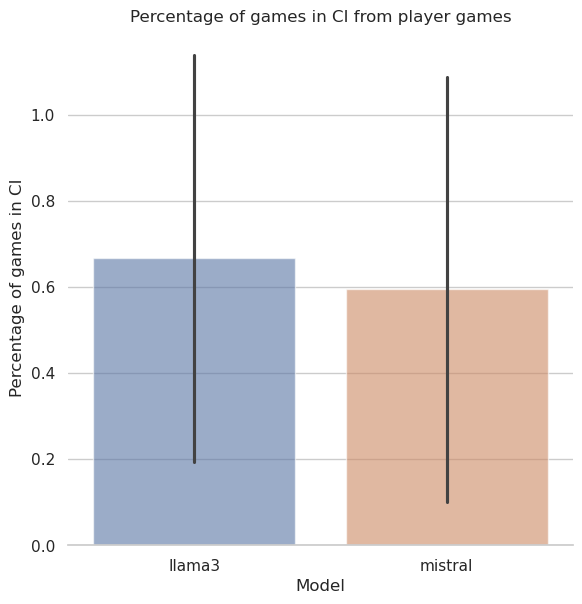

In [12]:
avglen['llama3_2007_in_CI'] = avglen.apply(lambda x: check_if_in_CI(x,'llama3_2007'), axis=1)
avglen["mistral_2007_in_CI"] = avglen.apply(lambda x: check_if_in_CI(x,'mistral_2007'), axis=1)
print(f'Number of LLM games in CI from player games: {avglen.llama3_2007_in_CI.mean()*100}%')
print(f'Number of Mistral games in CI from player games: {avglen.mistral_2007_in_CI.mean()*100}%')

# plot the number of games in CI

tmp_llama3 = avglen["llama3_2007_in_CI"].rename("in_CI").to_frame()
tmp_llama3["model"] = "llama3"
tmp_mistral = avglen["mistral_2007_in_CI"].rename("in_CI").to_frame()
tmp_mistral["model"] = "mistral"

ci_model = pd.concat([tmp_llama3, tmp_mistral])

sns.set_theme(style="whitegrid")
g = sns.catplot(x="model", y="in_CI", hue="model", data=ci_model, kind="bar", height=6, alpha=.6,errorbar="sd")
g.despine(left=True)
g.set_axis_labels("Model", "Percentage of games in CI")
plt.title("Percentage of games in CI from player games")

Jaccard similarity between player and llama3 2007: 0.27016937576944144
Jaccard similarity between player and mistral 2007: 0.32329015886677054


Text(0.5, 1.0, 'Jaccard similarity between player and model')

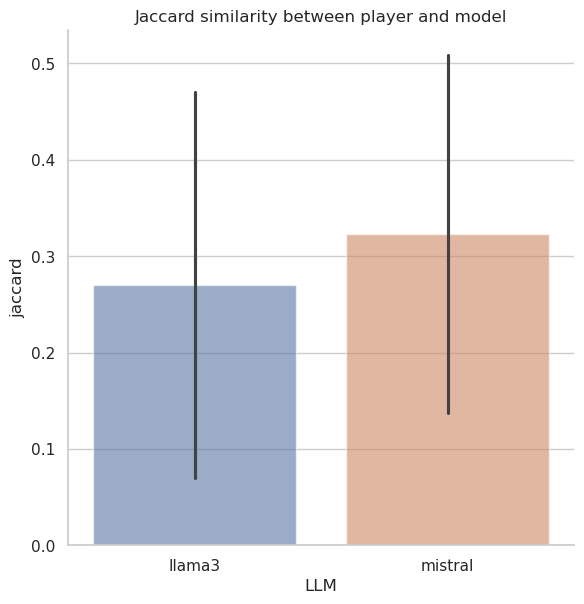

In [13]:
# compute jaccard similarity between player and model
players_2007 = players_2007["path"].apply(fix_path) # fix path for player by removing '<'
jaccard_llama3 = pd.merge(players_2007, llama3_2007, on=['start', 'end'], suffixes=('_x', '_y'))
jaccard_llama3['jaccard'] = jaccard_llama3.apply(jaccard_similarity, axis=1)
print(f'Jaccard similarity between player and llama3 2007: {jaccard_llama3["jaccard"].mean()}')

jaccard_mistral = pd.merge(players_2007, mistral_2007, on=['start', 'end'], suffixes=('_x', '_y'))
jaccard_mistral['jaccard'] = jaccard_mistral.apply(jaccard_similarity, axis=1)
print(f'Jaccard similarity between player and mistral 2007: {jaccard_mistral["jaccard"].mean()}')

jaccard_llama3["LLM"] = "llama3"
jaccard_mistral["LLM"] = "mistral"

jaccard = pd.concat([jaccard_llama3, jaccard_mistral])
sns.set_theme(style="whitegrid")
g = sns.catplot(x="LLM", y="jaccard", hue="LLM", data=jaccard, kind="bar", height=6, alpha=.6,errorbar="sd")
plt.title("Jaccard similarity between player and model")

In [14]:
# T-Test Compare the means of path lengths (human vs. model)
ttest_llama3 = ttest_ind(avglen['llama3_2007'], avglen['mean'])
ttest_mistral = ttest_ind(avglen['mistral_2007'], avglen['mean'])
print(f'T-Test between player and llama3 2007: {ttest_llama3}')
print(f'T-Test between player and mistral 2007: {ttest_mistral}')

T-Test between player and llama3 2007: TtestResult(statistic=1.1748021910869217, pvalue=0.24109380717803772, df=274.0)
T-Test between player and mistral 2007: TtestResult(statistic=3.2286406525332207, pvalue=0.0013952013335809983, df=274.0)


### Compare the results of the LLMs on 2007 and 2024

**Warning** : At the moment we should be critical about the results, because the llms only played each game once. In the future, we will have several games to compare in order to increase the confidence in the results.



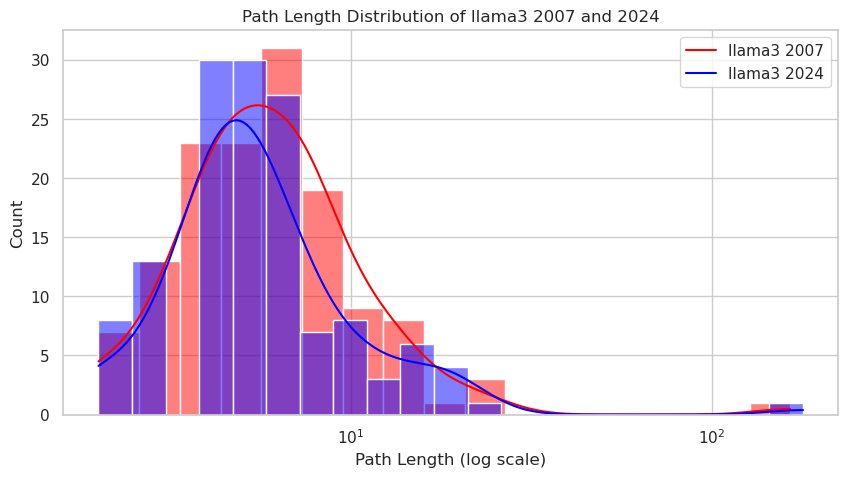

In [15]:
# plot path length distribution of llama3 2007 and 2024
plot_path_length_distribution(avglen, 'llama3',log_scale=True)

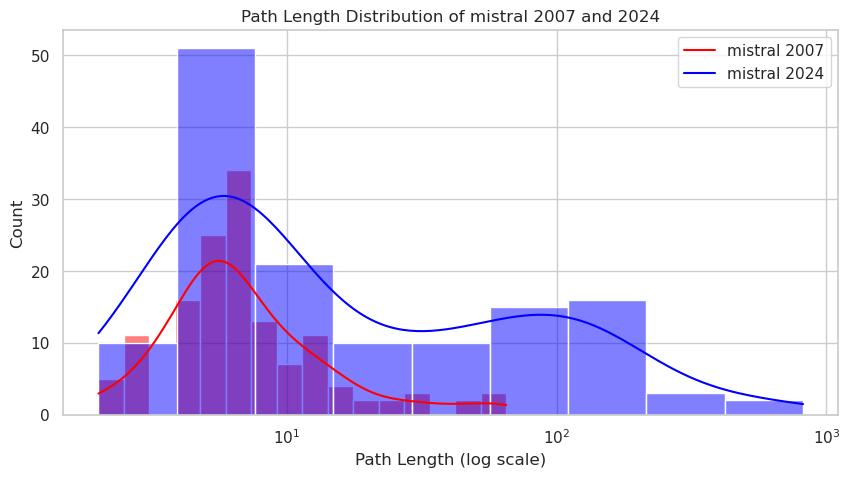

In [16]:
plot_path_length_distribution(avglen, 'mistral',log_scale=True)